
# Indian Buffet Process

Exploring the Indian Buffet Process (IBP).
This notebook follows the excellent paper [The Indian Buffet Process: An Introduction and Review](http://www.jmlr.org/papers/volume12/griffiths11a/griffiths11a.pdf) by Griffiths and Ghahramani, 2011.
Also see the paper [Bayesian Nonparametric Latent Feature Models](https://nms.kcl.ac.uk/peter.sollich/papers_pdf/Indian_Buffet.pdf) by Ghahramani, Griffiths and Sollich, 2007 that expands a little on the two-parameter IBP.

Imagine an Indian restaurant where a finite number of customers $N$ enter one at a time and encounter an infinite buffet of food choices.

 1. The first customer walks along the buffet line and samples all dishes until her plate is full afer $\text{Poisson}(\alpha)$ dishes.
 2. The $i^\text{th}$ customer then walks along and samples dishes proportionally to their popularity up to this point, serving themselves with probability $m_k/i$, where $m_k$ is the number of customers to have previously tried the $k^\text{th}$ dish.
    Then, the $i^\text{th}$ customer samples $\text{Poisson}(\alpha/i)$ new dishes.

In this way, the IBP defines a distribution over equivalence classes of binary matrices $Z$ with $N$ rows and un unbounded number of columns.
This process can be used as a prior for Machine Learning models that incorporate such a matrix.
For example, $Z$ could represent objects $\{i = 1, \dots, N\}$ each possessing some number of binary features.
Or, $Z$ can represent the adjacency matrix of a bipartite graph where the size of one of the groups is unknown and potentially unbounded.
By taking a hadamard (element-wise) product between $Z$ and some other matrix $V$, and imposing some prior on $V$, we can extend this to models where the $Z$ matrix defines existence of some number of features, and the $V$ matrix can allow for continuous or categorical feautre values (rather than binary features).


In [1]:

import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import poisson



## One-Parameter IBP

The one-parameter IBP is parameterized by a concentration parameter $\alpha \in (0, \infty)$, which sets the expected number of dishes each customer tries.

 * The number of dishes sampled by a customer (entries in any row) is distributed $\text{Poisson}(\alpha)$
 * The number of dish samples by all customers (entries in the whole matrix) is distributed $\text{Poisson}(N \alpha)$
 * The number of unique dishes tried by the customers (columns in the matrix) $K_+$ is distributed $\text{Poisson}(H_N \alpha)$, where $H_N = \sum_{i=1}^N 1/i$ is the $N^\text{th}$ harmonic number, and $N$ is the number of customers


In [2]:

# Fix the number of customers
N = 20


In [3]:

def ibp_oneparam(alpha, N):
    """One-parameter IBP"""

    # First customer
    Z = np.array([np.ones(poisson.rvs(alpha, size=1))], dtype=int)

    # ith customer
    for i in range(2, N+1):

        # Customer walks along previously sampled dishes
        z_i = []
        for previously_sampled_dish in Z.T:
            m_k = np.sum(previously_sampled_dish)
            if np.random.rand() <= m_k / i:
                # Customer decides to sample this dish
                z_i.append(1.0)
            else:
                # Customer decides to skip this dish
                z_i.append(0.0)

        # Customer decides to try some new dishes
        z_i.extend(np.ones(poisson.rvs(alpha / i, size=1)))
        z_i = np.array(z_i)

        # Add this customer to Z
        Z_new = np.zeros((
            Z.shape[0] + 1,
            max(Z.shape[1], len(z_i))
        ))
        Z_new[0:Z.shape[0], 0:Z.shape[1]] = Z
        Z = Z_new
        Z[i-1, :] = z_i
    
    return Z


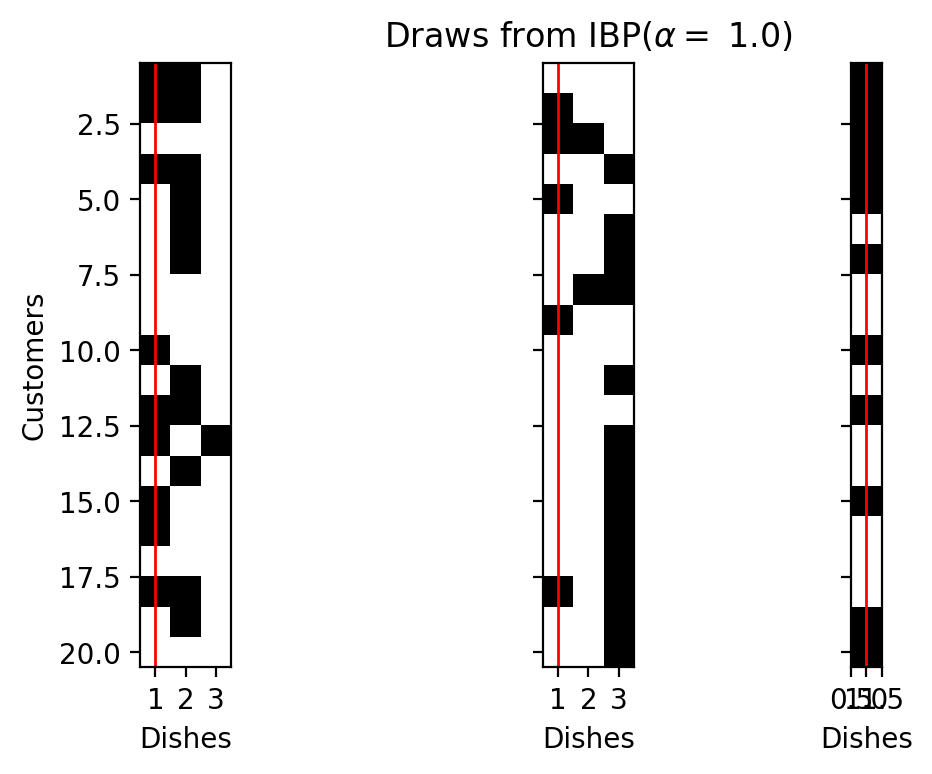

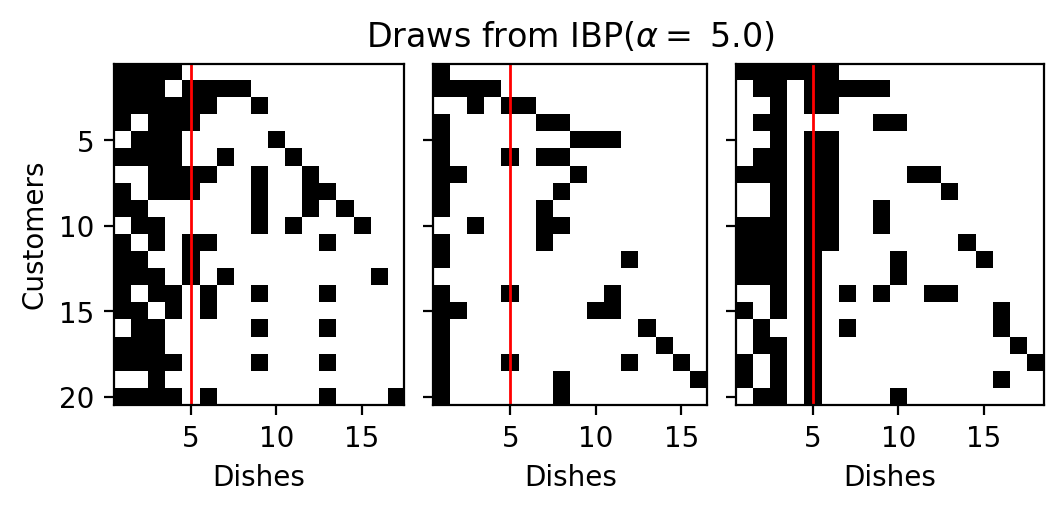

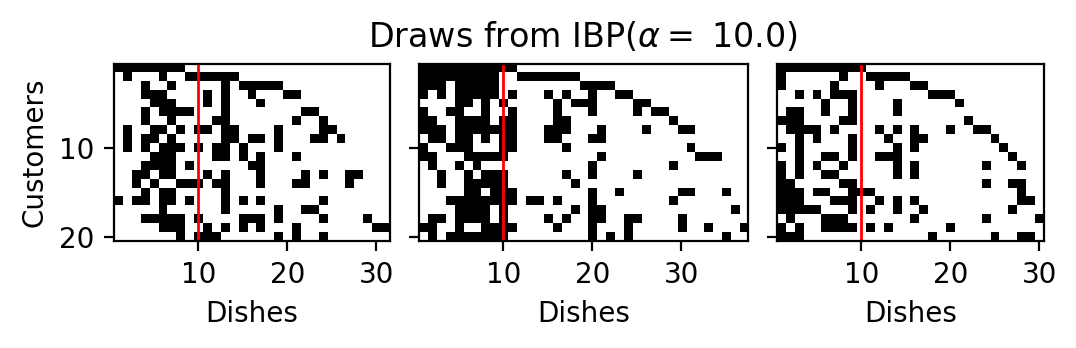

Below results are for N = 20, α = 10.0


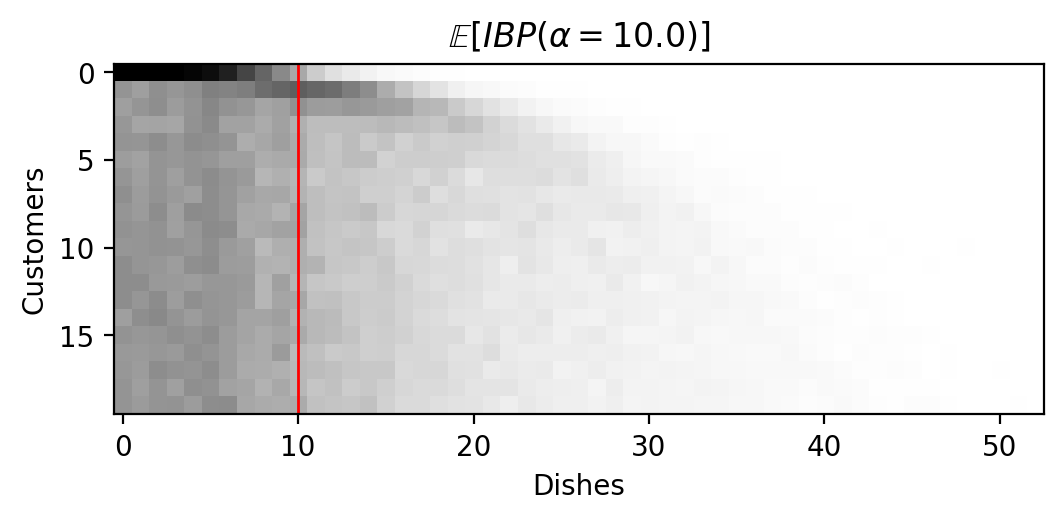

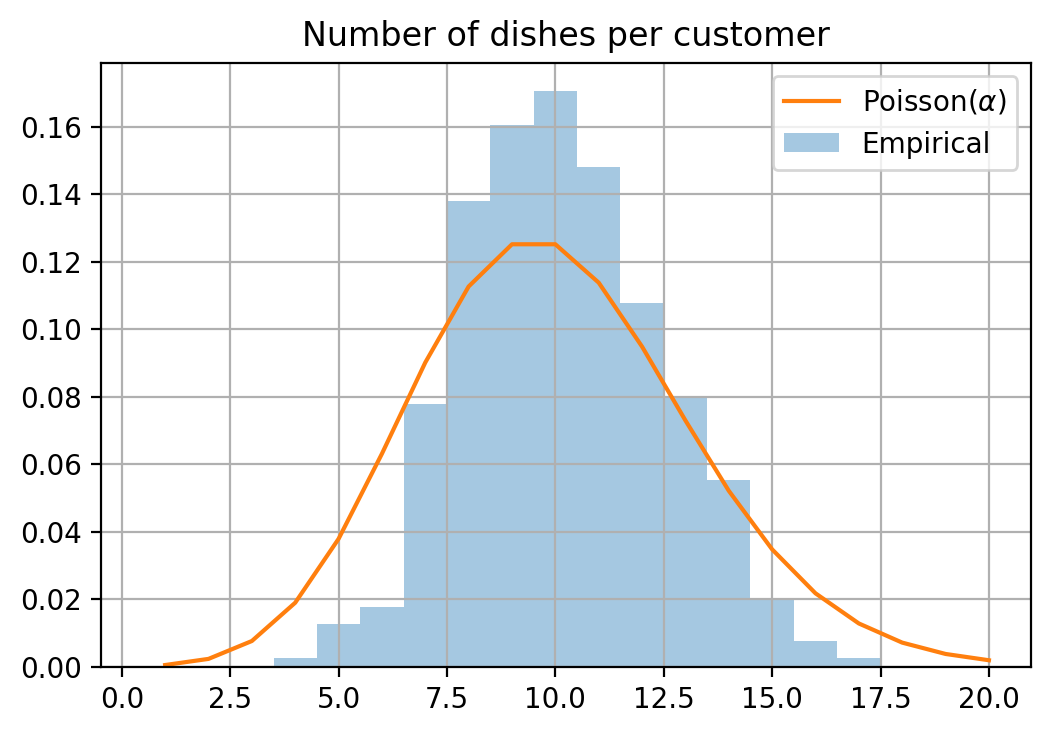

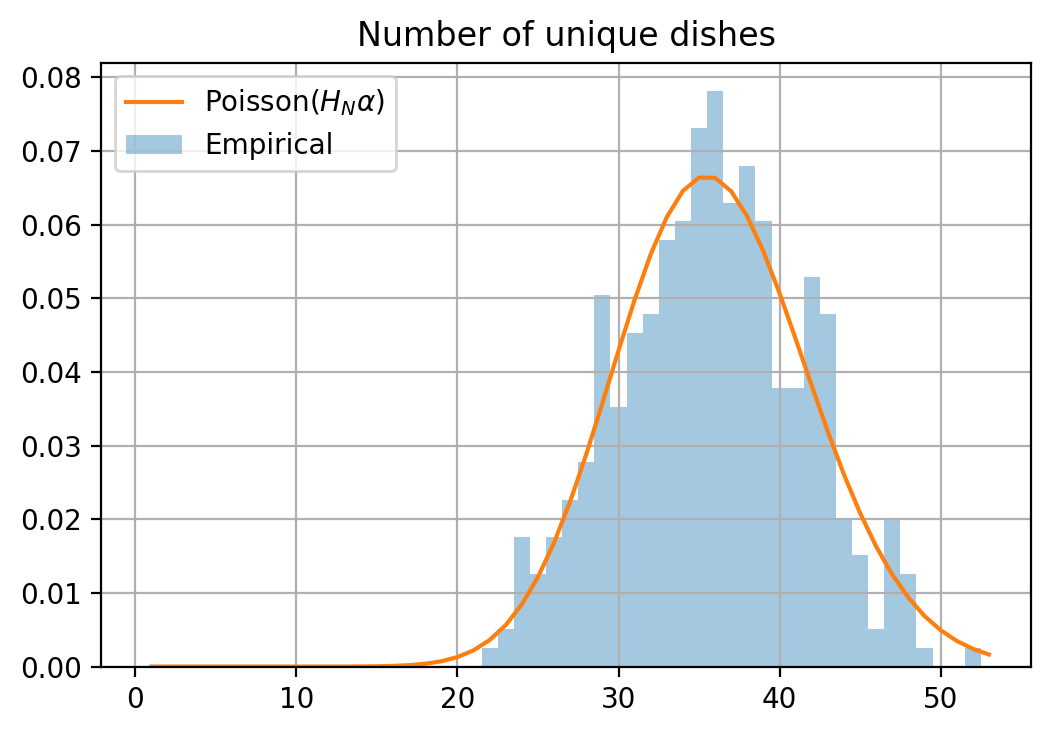

In [4]:

# Sweep values for alpha
alphas = [1.0, 5.0, 10.0]
for alpha in alphas:
    Zs = [ibp_oneparam(alpha, N) for _ in range(3)]

    fig, axes = plt.subplots(
        1,
        3,
        dpi=200,
        sharey=True,
        gridspec_kw=dict(
            width_ratios=[Z.shape[1] for Z in Zs],
            wspace=0.1
        )
    )

    for i, (ax, Z) in enumerate(zip(axes, Zs)):
        plt.sca(ax)
        plt.imshow(
            Z,
            extent=(0.5, Z.shape[1] + 0.5, len(Z) + 0.5, 0.5),
            cmap='Greys'
        )
        if i == 0:
            plt.ylabel("Customers")
        plt.xlabel("Dishes")
        plt.axvline(alpha, c='r', lw=1.0)

    axes[1].set_title(r"Draws from IBP($\alpha=$ " + str(alpha) + ")")
    plt.show()


# We can also compute the expectation of the IBP
print("Below results are for N = {}, α = {}".format(N, alpha))
num_samples = 400.0
Zs = [ibp_oneparam(alpha, N) for _ in range(int(num_samples))]
max_width = np.max([Z.shape[1] for Z in Zs])
Z_mean = np.zeros((N, max_width), dtype=float)
for Z in Zs:
    Z_mean[:, 0:Z.shape[1]] += Z / num_samples

plt.figure(dpi=200)
plt.imshow(Z_mean, cmap="Greys")
plt.axvline(alpha, c='r', lw=1.0)
plt.xlabel("Dishes")
plt.ylabel("Customers")
plt.title(r"$\mathbb{E}[IBP(\alpha=$" + str(alpha) + r"$)]$")
plt.show()

# Verify some statistics
num_dishes_per_customer = []
num_dishes = []
for Z in Zs:
    num_dishes_per_customer.append(np.sum(Z.flatten()) / N)
    num_dishes.append(np.sum(np.sum(Z, axis=0) > 0))

plt.figure(dpi=200)
x = np.arange(1.0, np.max(num_dishes_per_customer) + 1.0)
sns.distplot(
    num_dishes_per_customer,
    kde=False,
    bins=x - 0.5,
    norm_hist=True,
    label='Empirical'
)
plt.plot(x, poisson.pmf(x, alpha), label=r'Poisson($\alpha$)')
plt.title("Number of dishes per customer")
plt.grid()
plt.legend()
plt.show()

plt.figure(dpi=200)
x = np.arange(1.0, np.max(num_dishes) + 1.0)
H_n = np.sum([1/i for i in range(1, N + 1)])
sns.distplot(
    num_dishes,
    kde=False,
    bins=x - 0.5,
    norm_hist=True,
    label='Empirical'
)
plt.plot(x, poisson.pmf(x, H_n * alpha), label=r'Poisson($H_N \alpha$)')
plt.title("Number of unique dishes")
plt.grid()
plt.legend()
plt.show()
    


## Two-parameter IBP

In the one-parameter IBP, the dishes per customer and the total number of unique dishes are coupled.
That is, the amount of overlap between features (dishes) can be controlled.
The two-parameter IBP de-couples these terms.
As before, the paramter $\alpha \in (0, \infty)$ determines the expected number of dishes per customer, however a second paramter $\beta \in (0, \infty)$ determines the number of unique dishes $K_+$, with the possible range being from $\alpha$ to $N \alpha$ as $\beta$ changes.

The culinary metaphor for the two-parameter IBP is as follows;

 1. The first customer enters and samples $\text{Poisson}(\alpha)$ dishes as before
 2. The $i^\text{th}$ customer samples previously sampled dishes with probability $m_k / (\beta + i - 1)$, then decides to sample $\text{Poisson}(\alpha \beta / (\beta + i - 1))$ new dishes.

The two-parameter IBP has the following properties;

 * The number of dishes sampled by a customer (entries in any row) is distributed $\text{Poisson}(\alpha)$
 * The number of dish samples by all customers (entries in the whole matrix) is distributed $\text{Poisson}(N \alpha)$
 * The number of unique dishes tried by the customers $K_+$ is now distributed $\text{Poisson}(\alpha \sum_{i=1}^N \beta / (\beta + i - 1))$, such that setting $\beta = 1.0$ recovers the one-parameter IBP

Intuitively, for $\beta \to 0.0$, the dishes are 'sticky', and all customers will sample from the same dishes as the first one.
For $\beta \to \infty$, the dishes are 'repulsive', and the number of dishes will vary from $N \alpha$ to $\alpha \beta \log N$ as the number of customers increases.


In [5]:

def ibp_twoparam(alpha, beta, N):
    """Two-parameter IBP"""

    # First customer
    Z = np.array([np.ones(poisson.rvs(alpha, size=1))], dtype=int)

    # ith customer
    for i in range(2, N+1):

        # Customer walks along previously sampled dishes
        z_i = []
        for previously_sampled_dish in Z.T:
            m_k = np.sum(previously_sampled_dish)
            if np.random.rand() <= m_k / (beta + i - 1):
                # Customer decides to sample this dish
                z_i.append(1.0)
            else:
                # Customer decides to skip this dish
                z_i.append(0.0)

        # Customer decides to try some new dishes
        z_i.extend(np.ones(poisson.rvs(alpha * beta / (beta + i - 1), size=1)))
        z_i = np.array(z_i)

        # Add this customer to Z
        Z_new = np.zeros((
            Z.shape[0] + 1,
            max(Z.shape[1], len(z_i))
        ))
        Z_new[0:Z.shape[0], 0:Z.shape[1]] = Z
        Z = Z_new
        Z[i-1, :] = z_i
    
    return Z


def kplushat(alpha, beta, N):
    """Find the expected number of dishes given some paramters"""
    return alpha * np.sum([beta / (beta + i - 1) for i in range(1, N + 1)])


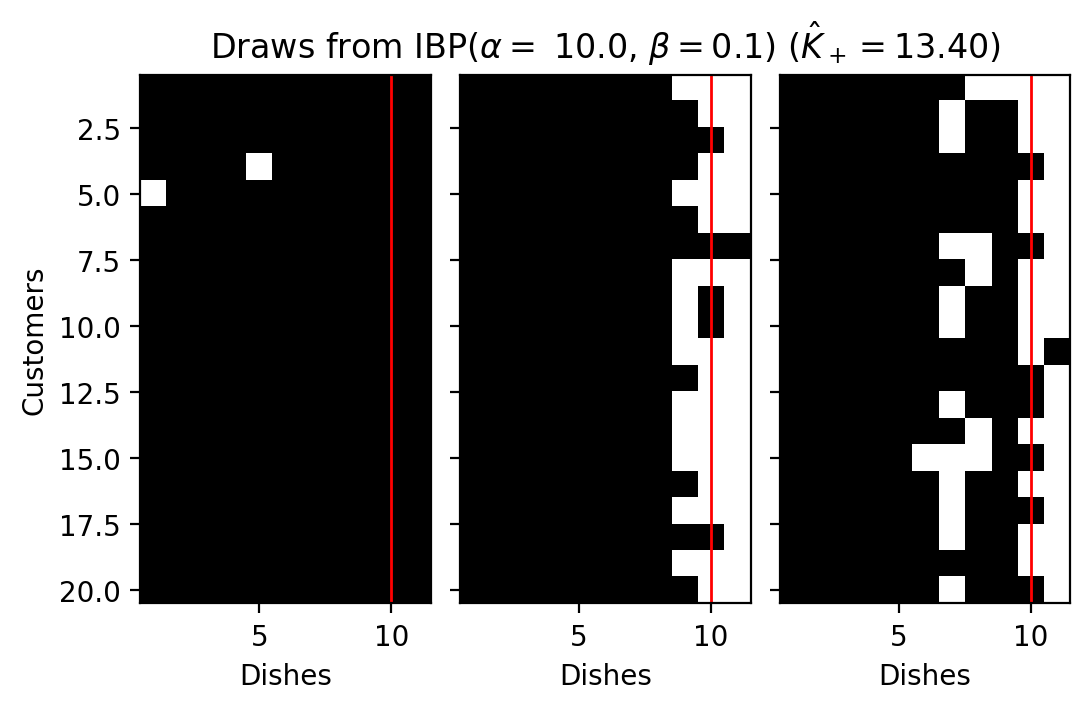

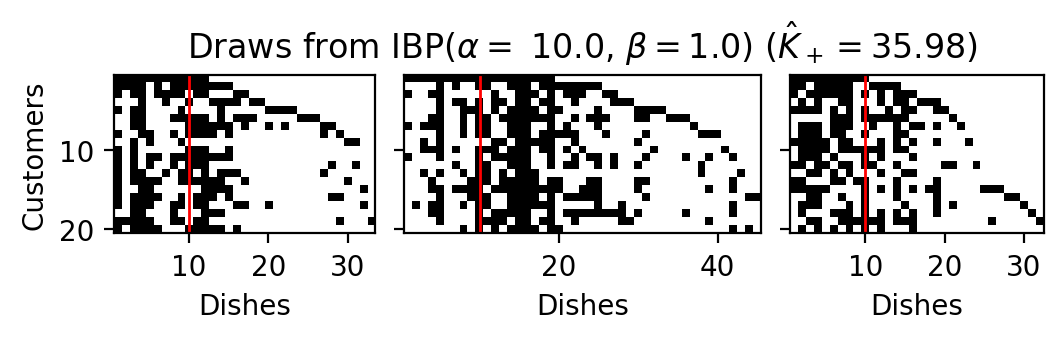

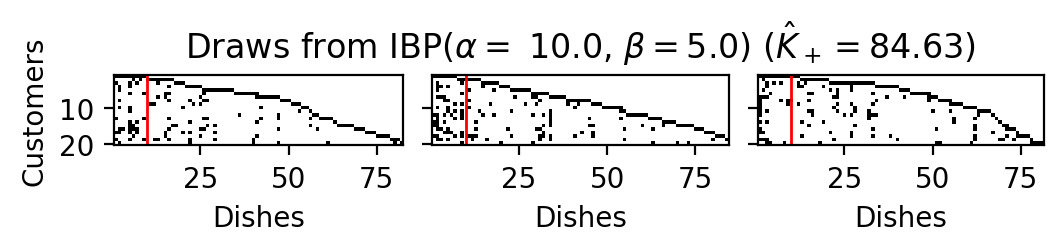

Below results are for N = 20, α = 10.0, β = 5.0


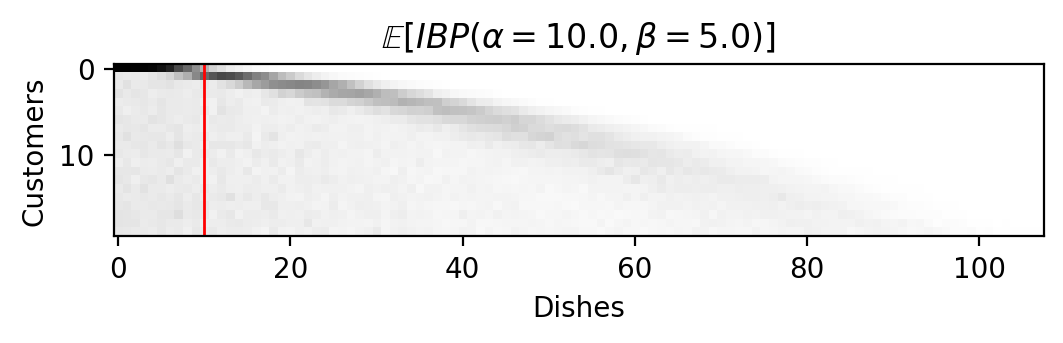

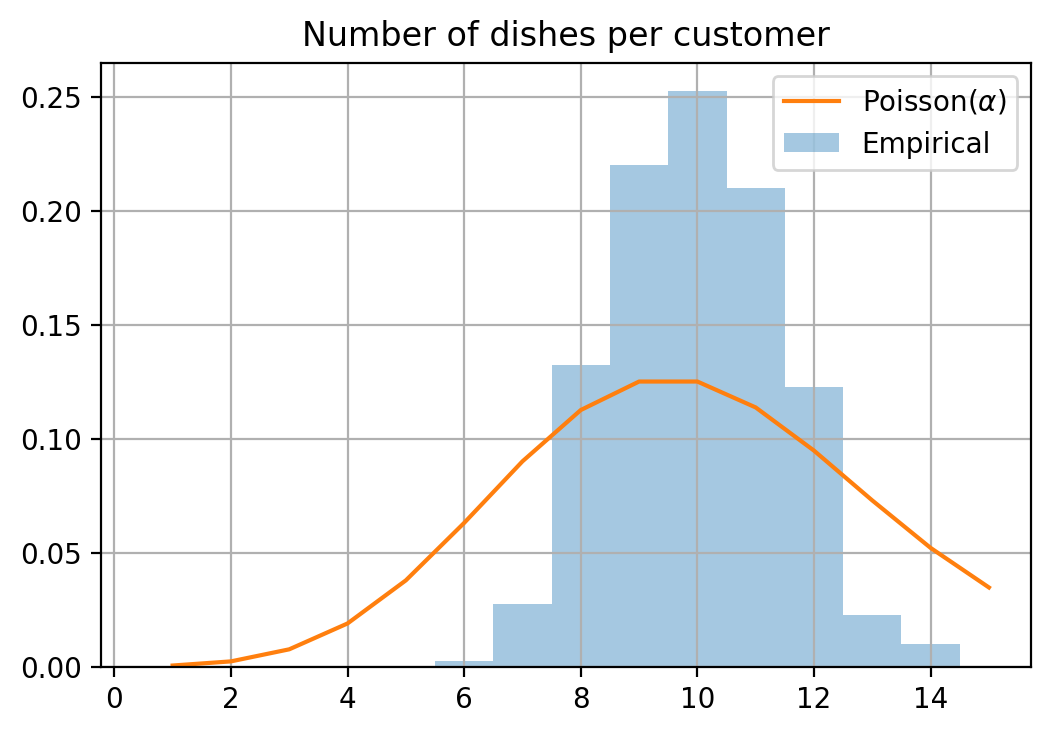

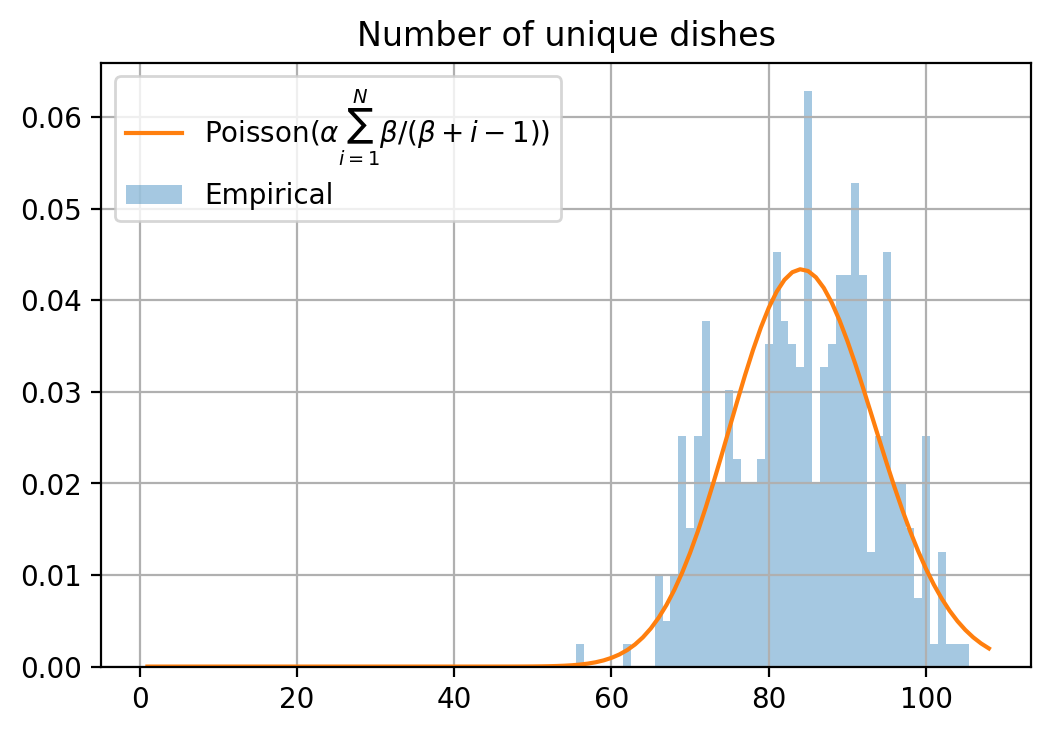

In [6]:

# Fix alpha and sweep values for beta
alpha = 10.0
betas = np.array([0.1, 1.0, 5.0])
for beta in betas:
    Zs = [ibp_twoparam(alpha, beta, N) for _ in range(3)]

    fig, axes = plt.subplots(
        1,
        3,
        dpi=200,
        sharey=True,
        gridspec_kw=dict(
            width_ratios=[Z.shape[1] for Z in Zs],
            wspace=0.1
        )
    )

    for i, (ax, Z) in enumerate(zip(axes, Zs)):
        plt.sca(ax)
        plt.imshow(
            Z,
            extent=(0.5, Z.shape[1] + 0.5, len(Z) + 0.5, 0.5),
            cmap='Greys'
        )
        if i == 0:
            plt.ylabel("Customers")
        plt.xlabel("Dishes")
        plt.axvline(alpha, c='r', lw=1.0)
    
    # Compute K+
    kph = kplushat(alpha, beta, N)
    axes[1].set_title(r"Draws from IBP($\alpha=$ " + str(alpha) + r", $\beta=$" + str(beta) + r") ($\hat{K}_+ = $" + "{:.2f}".format((kph)) + ")")
    plt.show()


# We can also compute the expectation of the IBP
print("Below results are for N = {}, α = {}, β = {}".format(N, alpha, beta))
num_samples = 400.0
Zs = [ibp_twoparam(alpha, beta, N) for _ in range(int(num_samples))]
max_width = np.max([Z.shape[1] for Z in Zs])
Z_mean = np.zeros((N, max_width), dtype=float)
for Z in Zs:
    Z_mean[:, 0:Z.shape[1]] += Z / num_samples

plt.figure(dpi=200)
plt.imshow(Z_mean, cmap="Greys")
plt.axvline(alpha, c='r', lw=1.0)
plt.xlabel("Dishes")
plt.ylabel("Customers")
plt.title(r"$\mathbb{E}[IBP(\alpha=$" + str(alpha) + r"$, \beta=$" + str(beta) + "$)]$")
plt.show()

# Verify some statistics
num_dishes_per_customer = []
num_dishes = []
for Z in Zs:
    num_dishes_per_customer.append(np.sum(Z.flatten()) / N)
    num_dishes.append(np.sum(np.sum(Z, axis=0) > 0))

plt.figure(dpi=200)
x = np.arange(1.0, np.max(num_dishes_per_customer) + 1.0)
sns.distplot(
    num_dishes_per_customer,
    kde=False,
    bins=x - 0.5,
    norm_hist=True,
    label='Empirical'
)
plt.plot(x, poisson.pmf(x, alpha), label=r'Poisson($\alpha$)')
plt.title("Number of dishes per customer")
plt.grid()
plt.legend()
plt.show()

plt.figure(dpi=200)
x = np.arange(1.0, np.max(num_dishes) + 1.0)
beta_term = np.sum([beta / (beta + i - 1) for i in range(1, N + 1)])
sns.distplot(
    num_dishes,
    kde=False,
    bins=x - 0.5,
    norm_hist=True,
    label='Empirical'
)
plt.plot(x, poisson.pmf(x, alpha * beta_term), label=r'Poisson($\alpha \sum_{i=1}^N \beta / (\beta +  i - 1)$)')
plt.title("Number of unique dishes")
plt.grid()
plt.legend()
plt.show()


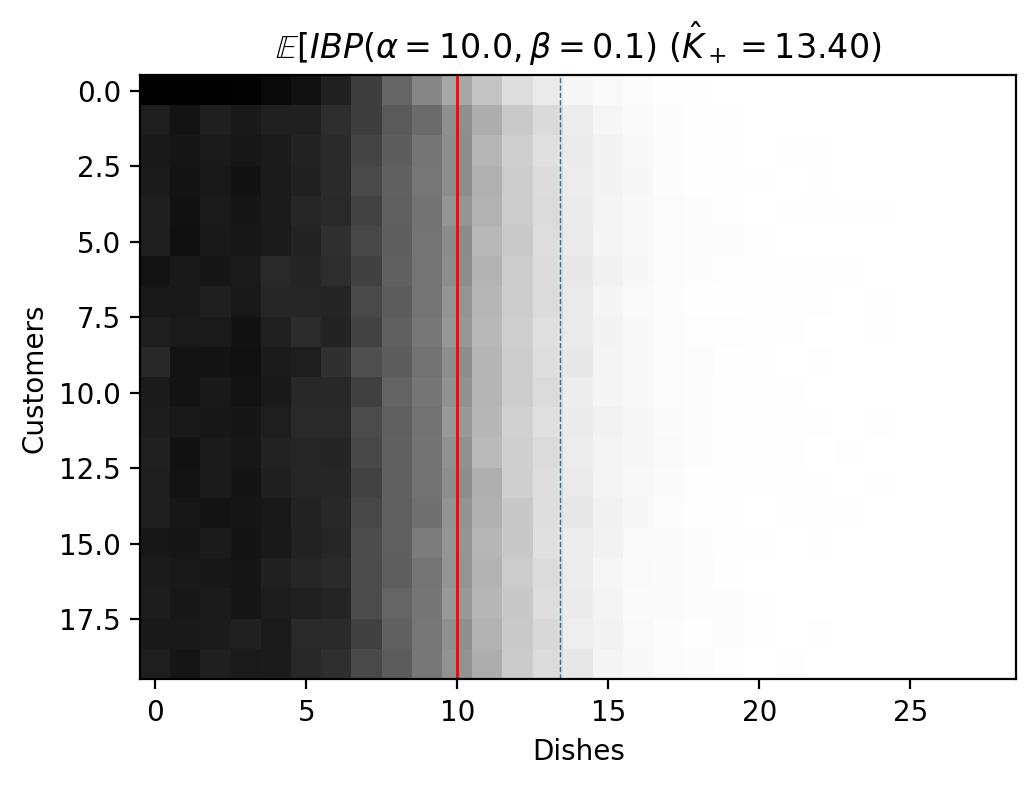

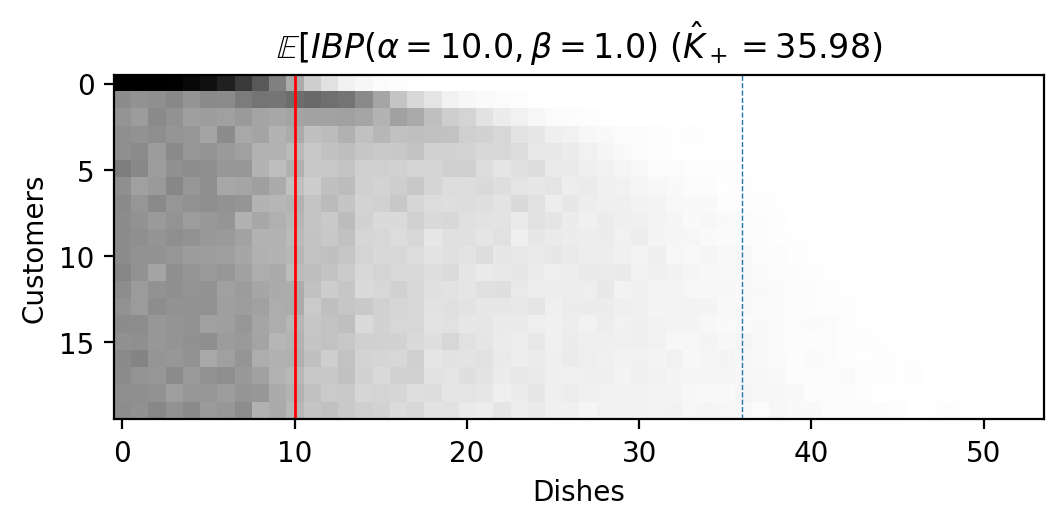

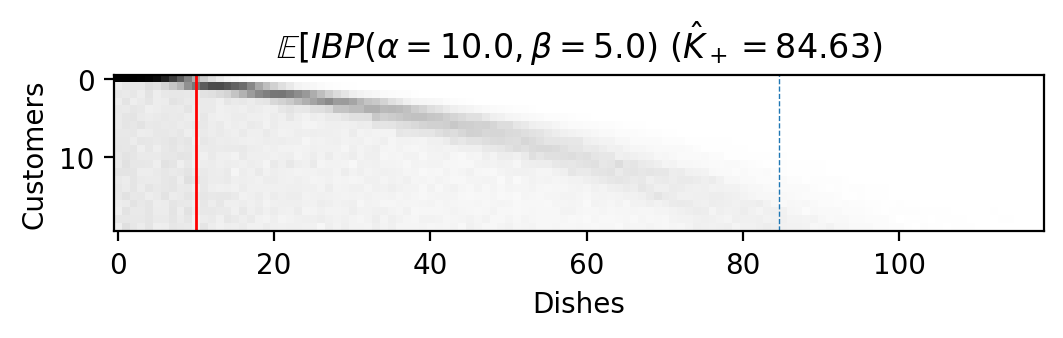

In [7]:

# Fix alpha and sweep values for beta
alpha = 10.0
betas = np.array([0.1, 1.0, 5.0])
for beta in betas:
    
    num_samples = 400.0
    Zs = [ibp_twoparam(alpha, beta, N) for _ in range(int(num_samples))]
    max_width = np.max([Z.shape[1] for Z in Zs])
    Z_mean = np.zeros((N, max_width), dtype=float)
    for Z in Zs:
        Z_mean[:, 0:Z.shape[1]] += Z / num_samples
    kph = kplushat(alpha, beta, N)

    plt.figure(dpi=200)
    plt.imshow(Z_mean, cmap="Greys")
    plt.axvline(alpha, c='r', lw=1.0)
    plt.axvline(kph, c='C0', ls='--', lw=0.5)
    plt.xlabel("Dishes")
    plt.ylabel("Customers")
    plt.title(r"$\mathbb{E}[IBP(\alpha=$" + str(alpha) + r"$, \beta=$" + str(beta) + r") ($\hat{K}_+ = $" + "{:.2f}".format((kph)) + ")")
    plt.show()
